In [24]:
from datetime import datetime
import sys

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from lib.data.santa_fe import load_santa_fe
from lib.models.mlp import MLP
from lib.utils.time_series import create_time_series_inputs_targets

# 2. Time-Series Prediction with a Neural Network

A time series is a sequence of observations, ordered in time. Forecasting involves training a model on historical data and using them to predict future observations. A simple example is a linear auto-regressive model. The linear auto-regressive (AR) model of a time-series $Z_t$ with $t = 1, 2,\ldots,\infty$ is given by:

$$
\hat{z}_t = a_1 z_{t-1} + a_2 z_{t-2} + \cdots + a_p z_{t-p},
$$

with $a_i \in \mathbb{R}$ for $i = 1,\ldots, p$ and $p$ the *model lag*. The prediction for a certain time $t$ is equal to a weighted sum of the previous values up to a certain lag $p$. In a similar way, the nonlinear variant (NAR) is described as:

$$
\hat{z}_t = f\left(z_{t-1}, z_{t-2}, \ldots, z_{t-p}\right).
$$

These processes can be depicted as follows (lag $p=2$):

<img alt="Schematic representation of the nonlinear auto-regressive model with lag p = 2." src=" 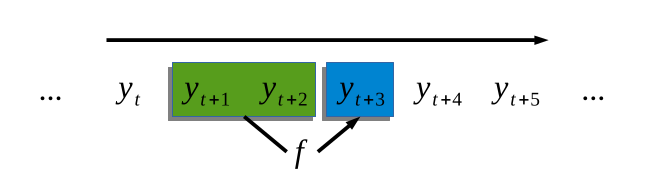"/>

Remark that in this way, the time-series identification can be written as a classical black-box regression modeling problem:

$$
\hat{y}_t = f(x_t) ,
$$

with $y_t = z_t$ and $x_t = [z_{t−1}, z_{t−2}, \ldots , z_{t−p}]$.

## 2.1 Sante Fe Dataset

The Santa Fe dataset is obtained from a chaotic laser which can be described as a nonlinear dynamical system. Given are 1000 training data points. The aim is to predict the next 100 points (it is forbidden to include these points in the training set!).

To load the test and training data, you can execute the cell below.

In [25]:
train_set, val_set = load_santa_fe()

You can visualize the time series with the following code:

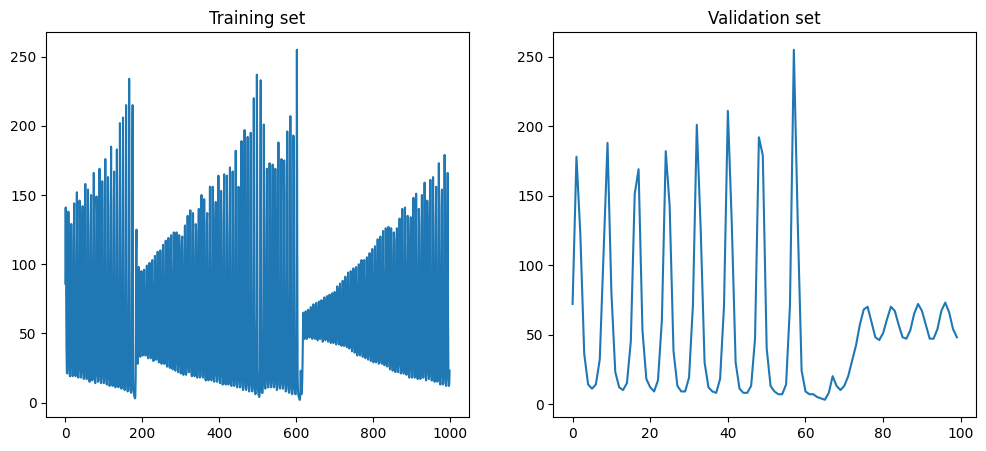

In [26]:
# Create Matplotlib figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the training set in the left subplot
axes[0].set_title("Training set")
axes[0].plot(train_set)

# Plot the validation set in the right subplot
axes[1].set_title("Validation set")
axes[1].plot(val_set)

As you can see, the data spans a large range. To make it easier for our network to fit the data, we can *normalize* the data by subtracting the mean and dividing by the data's standard deviation. You can compute the mean and norm of a tensor `t` easily with the following method calls:

```python
t.mean()  # Returns the mean of t
t.std()  # Returns the standard deviation of t
```

Use this to normalize the training and validation data. Note that you should use the mean and std of the training set to normalize both the training *and* the validation dataset.

In [27]:
# Standardize values
norm_train_set = torch.div((train_set - train_set.mean()), train_set.std())
norm_val_set = torch.div((val_set - val_set.mean()), val_set.std())

#Check if the standardization worked
print(f'train mean: {norm_train_set.mean()}, train std: {norm_train_set.std()}')
print(f'val mean: {norm_val_set.mean()}, val std: {norm_val_set.std()}')

train mean: -1.3351440841802287e-08, train std: 1.0
val mean: 2.1457672971791908e-08, val std: 1.0


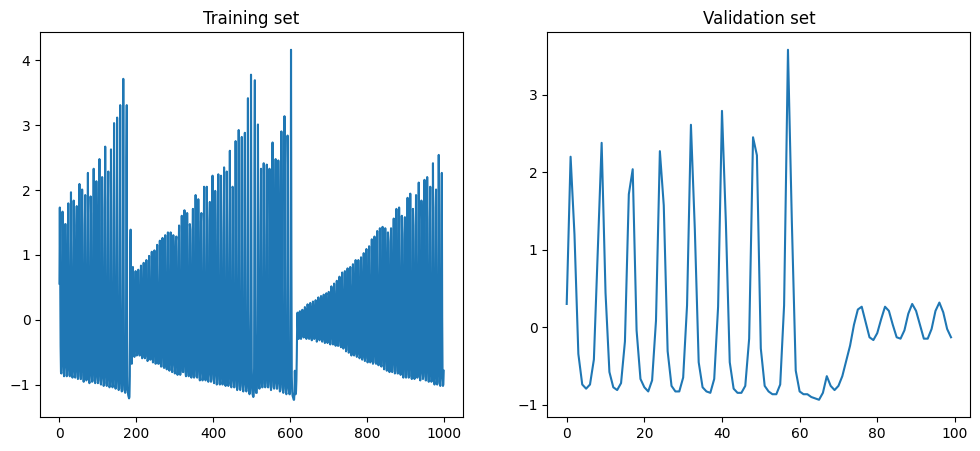

In [28]:
# Create Matplotlib figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the training set in the left subplot
axes[0].set_title("Training set")
axes[0].plot(norm_train_set)

# Plot the validation set in the right subplot
axes[1].set_title("Validation set")
axes[1].plot(norm_val_set)

## 2.2 Creating an MLP for Time-Series Prediction

An MLP for time-series prediction has $p$ inputs (the lag) and a single output. Using the `MLP` class from the previous exercise session (we have already imported it for you), create an MLP for time series prediction with a lag of 10 and 5 hidden neurons.

In [29]:
## Create an MLP for time series prediction ##
mlp = MLP(
    num_input_neurons=10,
    num_hidden_neurons=[5],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)

## 2.3 Training the MLP

The training is done in feedforward mode:

$$
\hat{y}_k = w^T \tanh\left(V[y_{k−1}, y_{k−2},\ldots, y_{k−p}] + \beta\right).
$$

We pass in $p$ successive data points from the time series and the model should predict the next data point. By comparing the predicted output with the true data point (e.g., via mean-squared error), we can compute a loss and train the network.

So, before we can start training, we will need a bunch of successive data points of length $p$ (the inputs), along with the data point that comes right after each sequence (the targets). To create these inputs and targets, you can use the provided function `create_time_series_inputs_targets()`. For example, to create a dataset with inputs and the corresponding targets for a network with a lag of 10, you can run the following code:

```python
inputs, targets = create_time_series_inputs_targets(my_time_series, 10)
```

where `my_time_series` is your time series (1D tensor). Make sure you understand what the function does by trying it out on a small self-made toy example.

In [30]:
## Create train_inputs and train_targets from the training dataset ##
train_inputs, train_targets = create_time_series_inputs_targets(norm_train_set, 10)

The `train_inputs` you have created in the previous cell can be used as a batch of training input data for the MLP. When passing this to the MLP, you will get a batch of predicted outputs, which can be compared with the ground-truth `train_targets`. From this, we can compute a loss value that can be optimized with gradient descent.

Now, write a `training_step()` function, based on the one from notebook `2_mlp.ipynb` of the previous exercise session. Define a suitable optimizer and loss function. Also define a `SummaryWriter` for the TensorBoard logs.

In [31]:
# Training step
def training_step(model, x_train, y_train, loss_fn, optimizer, writer, epoch):
    # Pass the training data through the model
    y_pred = model(x_train)

    # Compute the loss value
    loss = loss_fn(y_pred, y_train)

    # Clean up gradients from previous iteration
    optimizer.zero_grad()

    # Compute grad of loss wrt model params
    loss.backward()

    # Take optimization step
    optimizer.step()

    # Log the training loss
    writer.add_scalar(f"{loss_fn.__class__.__name__}/Train", loss, epoch)


In [32]:
# Create the optimizer
optimizer = optim.Adam(
    params=mlp.parameters(),
    lr=0.01
)

# Create a loss function
loss_fn = nn.MSELoss()

# Create a SummaryWriter instance
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'nn_time_series_{timestamp}'
writer = SummaryWriter(log_dir=f'run_nn_time_series/{run_name}')

Now you can train your network with the following loop. Don't forget to define the number of epochs. Note that `train_inputs` and `train_targets` should have been created with `create_time_series_inputs_targets()`.

In [33]:
NUM_EPOCHS = 1000
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp, train_inputs, train_targets, loss_fn, optimizer, writer, epoch)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 2.4 Making Time-Series Predictions

In order to make predictions, the trained network is used in an iterative way as a recurrent network:

$$
\hat{y}_k = w^T \tanh\left(V[\hat y_{k−1}, \hat y_{k−2},\ldots, \hat y_{k−p}] + \beta\right).
$$

As you can see, predictions from a previous time step ($\hat y_{k−*}$) are used to predict the output of the current time step. Indeed, to run a trained MLP for predicting a new time series, we must run the model *recurrently*. Complete the following implementation.

```python
@torch.no_grad()
def run_recurrent_model(model, x_0, num_iters):
    """
    Create a time series by recurrenctly feeding the output back into the input.
    """
    # Create a tensor to store the outputs in
    outputs = torch.zeros(num_iters)

    x_t = x_0
    for t in range(num_iters):
        # Compute the next value
        y_t = model(x_t)

        # Store the output
        outputs[t] = y_t

        # Create the input for the next time
        x_t = torch.cat([x_t[??], y_t]) # Shift the previous input and concatenate the output

    return outputs
```

In [34]:
# Predict multiple consequtive outputs
@torch.no_grad()
def run_recurrent_model(model, x_0, num_iters):
    """
    Create a time series by recurrenctly feeding the output back into the input.
    """
    # Create a tensor to store the outputs in
    outputs = torch.zeros(num_iters)

    x_t = x_0
    for t in range(num_iters):
        # Compute the next value
        y_t = model(x_t)

        # Store the output
        outputs[t] = y_t

        # Create the input for the next time
        x_t = torch.cat([x_t[1:], y_t]) # Shift the previous input and concatenate the output

    return outputs

In order to evaluate your MLP on the validation set, you can pass in the training dataset in `run_recurrent_model()` and compare the output with the time series in the validation set. Use the mean squared error for your comparison.

In [35]:
# The model is trained to predict the output using the 10 previous values
# To evaluate the model, pass the last 10 values of the training set and see if it predicts the next 100 values of the validation set

# Get the last 10 samples of the training set
input_samples = norm_train_set[-10:]

# Predict the 100 samples of the validation set
pred_samples = run_recurrent_model(mlp, input_samples, 100)

# Calculate the error
loss_fn = nn.MSELoss()
loss = loss_fn(pred_samples, norm_val_set)
print(loss)

tensor(nan)


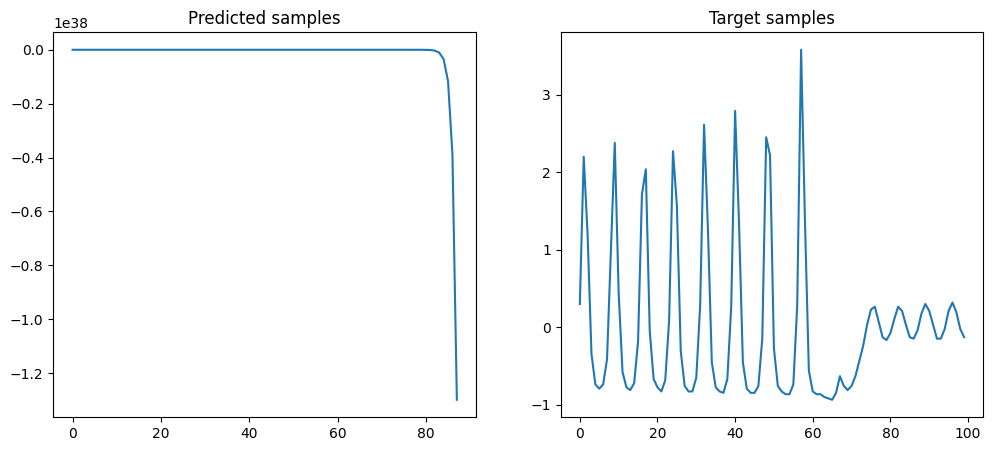

In [36]:
def visualize_prediction_performance(pred_samples, target_samples):
    # Create Matplotlib figure and axes
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    axes[0].set_title("Predicted samples")
    axes[0].plot(pred_samples)

    axes[1].set_title("Target samples")
    axes[1].plot(target_samples)

visualize_prediction_performance(pred_samples, norm_val_set)

## 2.5 Exercise

Train an MLP with one hidden layer **after normalizing** the Santa Fe dataset. Investigate the model performance with different lags and number of neurons. Explain clearly how you tune the parameters and what the influence is on the final prediction. Which combination of parameters gives the best performance on the test set?

### Different lags

In [37]:
# Get the dataset
train_set, val_set = load_santa_fe()

#Standardize values
norm_train_set = torch.div((train_set - train_set.mean()), train_set.std())
norm_val_set = torch.div((val_set - val_set.mean()), val_set.std())

# Create the train features and targets with different lags
train_inputs_lag_10, train_targets_lag_10 = create_time_series_inputs_targets(norm_train_set, 10)
train_inputs_lag_200, train_targets_lag_200 = create_time_series_inputs_targets(norm_train_set, 200)
train_inputs_lag_500, train_targets_lag_500 = create_time_series_inputs_targets(norm_train_set, 500)

In [38]:
# Create the mlp models with the different 
mlp_lag_10 = MLP(
    num_input_neurons=10,
    num_hidden_neurons=[5],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)
mlp_lag_200 = MLP(
    num_input_neurons=200,
    num_hidden_neurons=[5],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)
mlp_lag_500 = MLP(
    num_input_neurons=500,
    num_hidden_neurons=[5],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)

In [39]:
# Train the different models  with different neurons

# Create the optimizers
optimizer_lag_10 = optim.Adam(
    params=mlp_lag_10.parameters(),
    lr=0.01
)
optimizer_lag_200 = optim.Adam(
    params=mlp_lag_200.parameters(),
    lr=0.01
)
optimizer_lag_500 = optim.Adam(
    params=mlp_lag_500.parameters(),
    lr=0.01
)

# Create a loss function
loss_fn = nn.MSELoss()

# Create the SummaryWriter instance
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name_lag_10 = f'nn_time_series_lag_10_{timestamp}'
run_name_lag_200 = f'nn_time_series_lag_200_{timestamp}'
run_name_lag_500 = f'nn_time_series_lag_500_{timestamp}'
writer_lag_10 = SummaryWriter(log_dir=f'run_nn_time_series/{run_name_lag_10}')
writer_lag_200 = SummaryWriter(log_dir=f'run_nn_time_series/{run_name_lag_200}')
writer_lag_500 = SummaryWriter(log_dir=f'run_nn_time_series/{run_name_lag_500}')


NUM_EPOCHS = 1000

# Train the different models
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp_lag_10, train_inputs_lag_10, train_targets_lag_10, loss_fn, optimizer_lag_10, writer_lag_10, epoch)
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp_lag_200, train_inputs_lag_200, train_targets_lag_200, loss_fn, optimizer_lag_200, writer_lag_200, epoch)
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp_lag_500, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_lag_500, writer_lag_500, epoch)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
# Get the different inputs for validation
input_samples_10 = norm_train_set[-10:]
input_samples_200 = norm_train_set[-200:]
input_samples_500 = norm_train_set[-500:]

# Predict the 100 samples of the validation set
pred_samples_lag_10 = run_recurrent_model(mlp_lag_10, input_samples_10, 100)
pred_samples_lag_200 = run_recurrent_model(mlp_lag_200, input_samples_200, 100)
pred_samples_lag_500 = run_recurrent_model(mlp_lag_500, input_samples_500, 100)


# Calculate the error
loss_fn = nn.MSELoss()
loss_lag_10 = loss_fn(pred_samples_lag_10, norm_val_set)
loss_lag_200 = loss_fn(pred_samples_lag_200, norm_val_set)
loss_lag_500 = loss_fn(pred_samples_lag_500, norm_val_set)

print(f'val loss lag 10: {loss_lag_10}, val loss lag 200: {loss_lag_200}, val loss lag 500: {loss_lag_500},')

val loss lag 10: nan, val loss lag 200: 2.633899450302124, val loss lag 500: 0.9452607035636902,


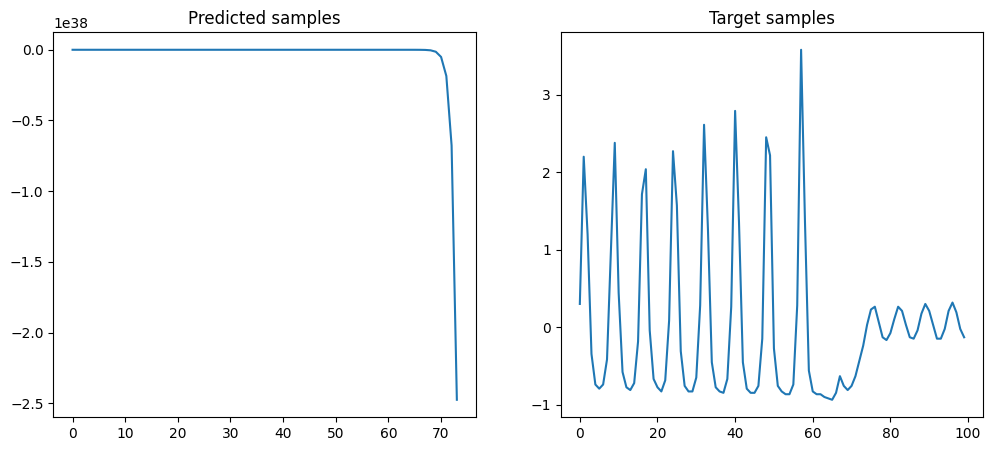

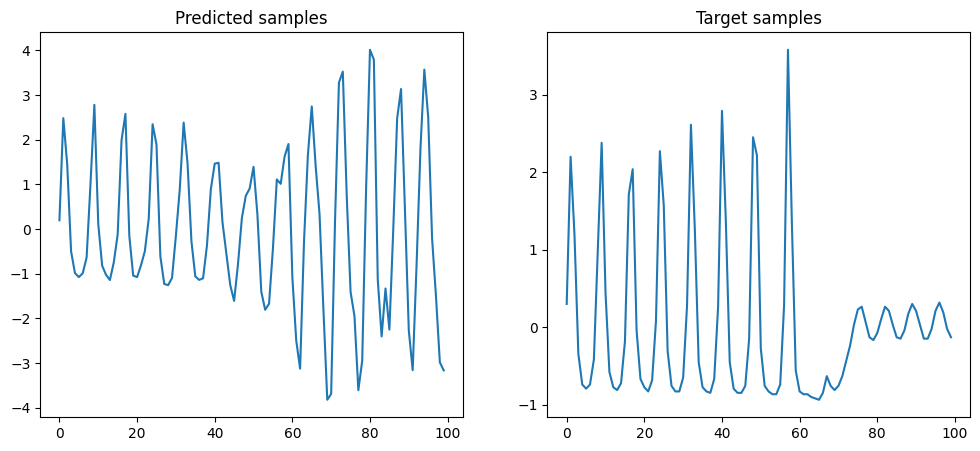

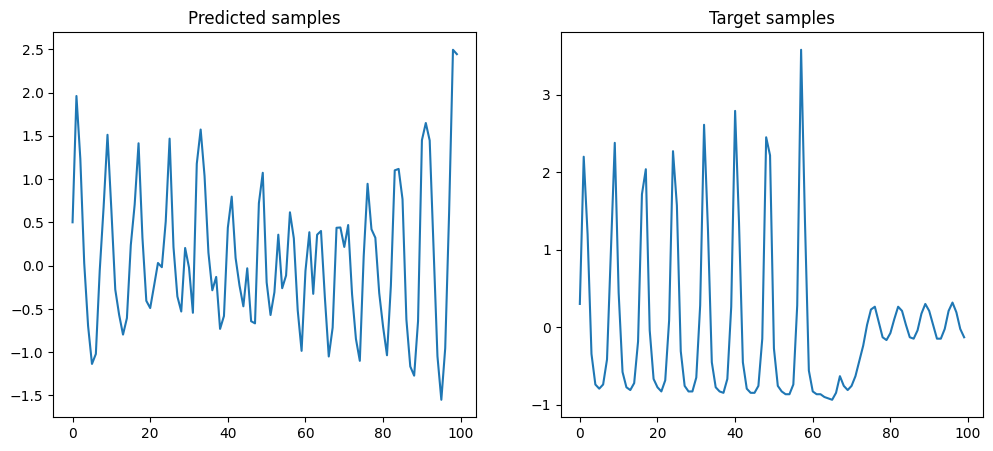

In [41]:
visualize_prediction_performance(pred_samples_lag_10, norm_val_set)
visualize_prediction_performance(pred_samples_lag_200, norm_val_set)
visualize_prediction_performance(pred_samples_lag_500, norm_val_set)

### Different Neurons

In [42]:
# Get the dataset
train_set, val_set = load_santa_fe()

#Standardize values
norm_train_set = torch.div((train_set - train_set.mean()), train_set.std())
norm_val_set = torch.div((val_set - val_set.mean()), val_set.std())

# Create the train features and targets
train_inputs_lag_500, train_targets_lag_500 = create_time_series_inputs_targets(norm_train_set, 500)

In [43]:
# Create 3 mlp's with different numbers of hidden neurons
mlp_neur_5 = MLP(
    num_input_neurons=500,
    num_hidden_neurons=[5],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)

mlp_neur_25 = MLP(
    num_input_neurons=500,
    num_hidden_neurons=[25],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)

mlp_neur_50 = MLP(
    num_input_neurons=500,
    num_hidden_neurons=[50],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)

In [44]:
# Train the different models  with different neurons

# Create the optimizers
optimizer_neur_5 = optim.Adam(
    params=mlp_neur_5.parameters(),
    lr=0.01
)
optimizer_neur_25 = optim.Adam(
    params=mlp_neur_25.parameters(),
    lr=0.01
)
optimizer_neur_50 = optim.Adam(
    params=mlp_neur_50.parameters(),
    lr=0.01
)

# Create a loss function
loss_fn = nn.MSELoss()

# Create the SummaryWriter instances
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name_neur_5 = f'nn_time_series_neur_5_{timestamp}'
run_name_neur_25 = f'nn_time_series_neur_25_{timestamp}'
run_name_neur_50 = f'nn_time_series_neur_50_{timestamp}'
writer_neur_5 = SummaryWriter(log_dir=f'run_nn_time_series/{run_name_neur_5}')
writer_neur_25 = SummaryWriter(log_dir=f'run_nn_time_series/{run_name_neur_25}')
writer_neur_50 = SummaryWriter(log_dir=f'run_nn_time_series/{run_name_neur_50}')


NUM_EPOCHS = 1000

# Train the different models
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp_neur_5, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_neur_5, writer_neur_5, epoch)
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp_neur_25, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_neur_25, writer_neur_25, epoch)
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp_neur_50, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_neur_50, writer_neur_50, epoch)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
# Validate the models with the different neurons

# Predict the 100 samples of the validation set
pred_samples_neur_5 = run_recurrent_model(mlp_neur_5, input_samples_500, 100)
pred_samples_neur_25 = run_recurrent_model(mlp_neur_25, input_samples_500, 100)
pred_samples_neur_50 = run_recurrent_model(mlp_neur_50, input_samples_500, 100)


# Calculate the error
loss_fn = nn.MSELoss()
loss_neur_5 = loss_fn(pred_samples_neur_5, norm_val_set)
loss_neur_25 = loss_fn(pred_samples_neur_25, norm_val_set)
loss_neur_50 = loss_fn(pred_samples_neur_50, norm_val_set)

print(f'val loss n5: {loss_neur_5}, val loss n25: {loss_neur_25}, val loss n50: {loss_neur_50},')

val loss n5: 1.36622953414917, val loss n25: 1.080503225326538, val loss n50: 0.9881589412689209,


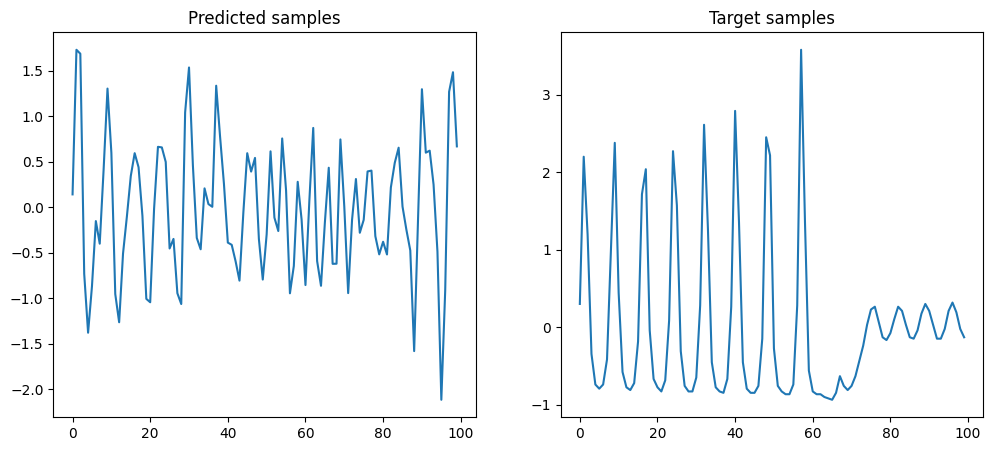

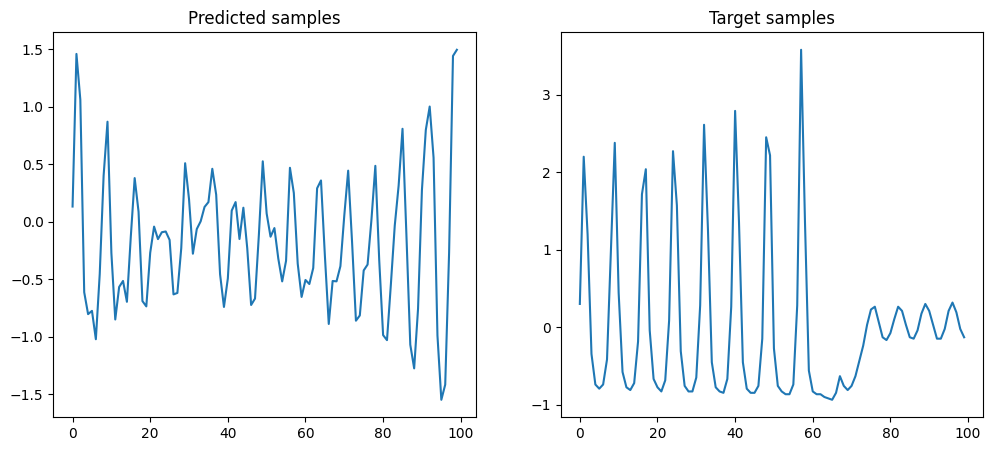

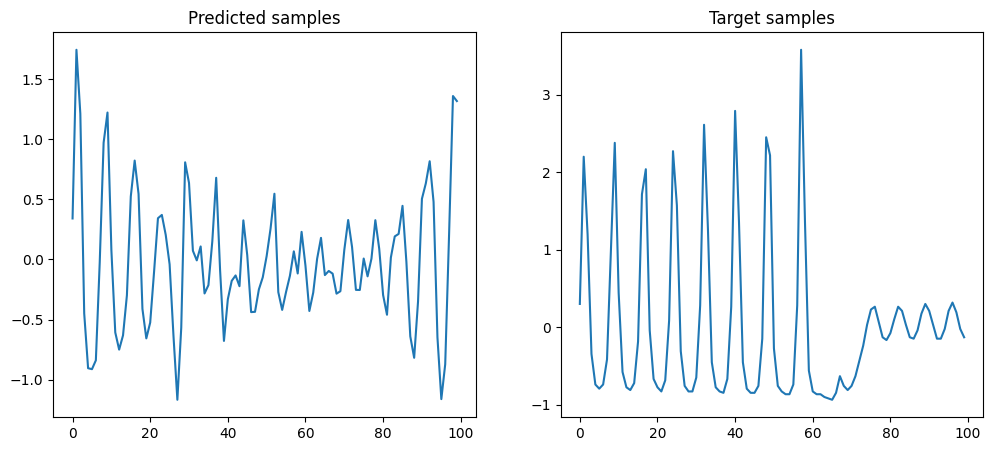

In [46]:
# Visualize performance
visualize_prediction_performance(pred_samples_neur_5, norm_val_set)
visualize_prediction_performance(pred_samples_neur_25, norm_val_set)
visualize_prediction_performance(pred_samples_neur_50, norm_val_set)